In [600]:
# 판다스와 넘파이
import pandas as pd
import numpy as np

# 이미지
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#머신러닝
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 검증 평가
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 기타
from tqdm import tqdm
import warnings ; warnings.filterwarnings('ignore')

In [601]:
objective : "mae"

In [602]:
# train 데이터, date 컬럼 datetime 데이터로 변경
train = pd.read_csv('train.csv', encoding='cp949')
train['date_time'] = pd.to_datetime(train['date_time'])

# test 데이터, date 컬럼 datetime 데이터로 변경
test = pd.read_csv('test.csv', encoding='cp949')
test['date_time'] = pd.to_datetime(test['date_time'])

In [603]:
train.columns

Index(['num', 'date_time', 'temperature', 'windspeed(m/s)', 'humidity(%)',
       'precipitation(mm)', 'sunshine(hr)', 'non_electric_cooling_system',
       'solar_cell', 'consumption(kWh)'],
      dtype='object')

## Base

In [604]:
X = train.drop(['date_time', 'consumption(kWh)'], axis = 1)
y = train['consumption(kWh)']
X_test = test.drop('date_time', axis = 1)

In [605]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold

n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(X_test))

# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for tr_idx, val_idx in sfk.split(X, X['num']):      
    X_train = X.iloc[tr_idx, :]
    y_train = y[tr_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.1,objective = 'mse')
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 100)
    y_pred += lgbm.predict(X_test) / n_splits

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 677.13	valid_0's l2: 458505
[200]	valid_0's rmse: 676.28	valid_0's l2: 457354
Early stopping, best iteration is:
[205]	valid_0's rmse: 676.12	valid_0's l2: 457139
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 774.695	valid_0's l2: 600152
[200]	valid_0's rmse: 771.763	valid_0's l2: 595618
Early stopping, best iteration is:
[156]	valid_0's rmse: 771.466	valid_0's l2: 595160
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 767.615	valid_0's l2: 589233
Early stopping, best iteration is:
[84]	valid_0's rmse: 767.124	valid_0's l2: 588479
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 875.827	valid_0's l2: 767073
[200]	valid_0's rmse: 873.723	valid_0's l2: 763392
Early stopping, best iteration is:
[199]	valid_0's rmse: 873.709	valid_0's l2: 763368
Training until validation scores don't improve for 50 round

## 방향잡기

### Hint
- num : house identity
- 건물마다 소비전력이 다르다.
- 건물별로 나누고, 소비전력값을 추출한다.
- LGBM 돌릴때 object가 리그레션 l1, l2 등등 중 여러가지써보기

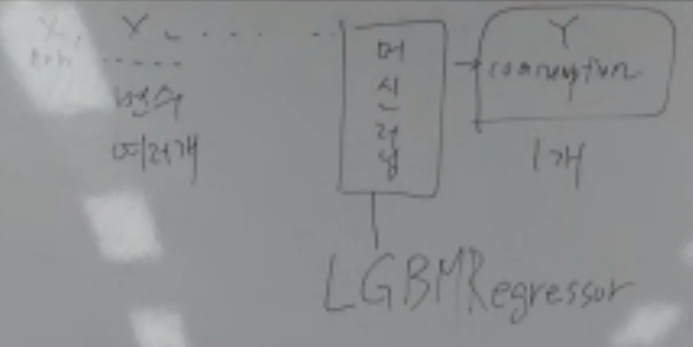

In [606]:
train.head()

,num,date_time,temperature,windspeed(m/s),humidity(%),precipitation(mm),sunshine(hr),non_electric_cooling_system,solar_cell,consumption(kWh)
0,1,2020-06-01 00:00:00,17.6,2.5,92.0,0.8,0.0,0,0,8179.056
1,1,2020-06-01 01:00:00,17.7,2.9,91.0,0.3,0.0,0,0,8135.640
2,1,2020-06-01 02:00:00,17.5,3.2,91.0,0.0,0.0,0,0,8107.128
3,1,2020-06-01 03:00:00,17.1,3.2,91.0,0.0,0.0,0,0,8048.808
4,1,2020-06-01 04:00:00,17.0,3.3,92.0,0.0,0.0,0,0,8043.624


In [607]:
test.head()

,num,date_time,temperature,windspeed(m/s),humidity(%),precipitation(mm),sunshine(hr),non_electric_cooling_system,solar_cell
0,1,2020-06-01 06:00:00,16.7,3.4,90.0,0.1,0.0,0,0
1,1,2020-06-01 11:00:00,22.1,3.6,52.0,0.0,1.0,0,0
2,1,2020-06-01 13:00:00,23.1,5.1,42.0,0.0,1.0,0,0
3,1,2020-06-02 02:00:00,15.9,1.1,78.0,0.0,0.0,0,0
4,1,2020-06-02 04:00:00,15.5,0.9,79.0,0.0,0.0,0,0


In [608]:
train['date_time'] = pd.to_datetime(train['date_time'])
train['datetime_year'] = train['date_time'].dt.year
train['datetime_month'] = train['date_time'].dt.month
train['datetime_day'] = train['date_time'].dt.day
train['datetime_hour'] = train['date_time'].dt.hour
train['datetime_minute'] = train['date_time'].dt.minute
train['datetime_second'] = train['date_time'].dt.second
train['weekday'] = train['date_time'].dt.weekday + 1
train['datetime_weekday'] = train['date_time'].dt.day_name()

train[['date_time', 'datetime_year', 'datetime_month', 'datetime_day',
      'datetime_hour', 'weekday', 'datetime_weekday']]

,date_time,datetime_year,datetime_month,datetime_day,datetime_hour,weekday,datetime_weekday
0,2020-06-01 00:00:00,2020,6,1,0,1,Monday
1,2020-06-01 01:00:00,2020,6,1,1,1,Monday
2,2020-06-01 02:00:00,2020,6,1,2,1,Monday
3,2020-06-01 03:00:00,2020,6,1,3,1,Monday
4,2020-06-01 04:00:00,2020,6,1,4,1,Monday
...,...,...,...,...,...,...,...
97915,2020-08-24 19:00:00,2020,8,24,19,1,Monday
97916,2020-08-24 20:00:00,2020,8,24,20,1,Monday
97917,2020-08-24 21:00:00,2020,8,24,21,1,Monday
97918,2020-08-24 22:00:00,2020,8,24,22,1,Monday


In [609]:
test['date_time'] = pd.to_datetime(test['date_time'])
test['datetime_year'] = test['date_time'].dt.year
test['datetime_month'] = test['date_time'].dt.month
test['datetime_day'] = test['date_time'].dt.day
test['datetime_hour'] = test['date_time'].dt.hour
test['datetime_minute'] = test['date_time'].dt.minute
test['datetime_second'] = test['date_time'].dt.second
test['weekday'] = test['date_time'].dt.weekday + 1

test[['date_time', 'datetime_year', 'datetime_month', 'datetime_day',
      'datetime_hour', 'weekday']]

,date_time,datetime_year,datetime_month,datetime_day,datetime_hour,weekday
0,2020-06-01 06:00:00,2020,6,1,6,1
1,2020-06-01 11:00:00,2020,6,1,11,1
2,2020-06-01 13:00:00,2020,6,1,13,1
3,2020-06-02 02:00:00,2020,6,2,2,2
4,2020-06-02 04:00:00,2020,6,2,4,2
...,...,...,...,...,...,...
24475,2020-08-24 01:00:00,2020,8,24,1,1
24476,2020-08-24 02:00:00,2020,8,24,2,1
24477,2020-08-24 09:00:00,2020,8,24,9,1
24478,2020-08-24 15:00:00,2020,8,24,15,1


In [610]:
train.columns

Index(['num', 'date_time', 'temperature', 'windspeed(m/s)', 'humidity(%)',
       'precipitation(mm)', 'sunshine(hr)', 'non_electric_cooling_system',
       'solar_cell', 'consumption(kWh)', 'datetime_year', 'datetime_month',
       'datetime_day', 'datetime_hour', 'datetime_minute', 'datetime_second',
       'weekday', 'datetime_weekday'],
      dtype='object')

<AxesSubplot:xlabel='weekday', ylabel='consumption(kWh)'>

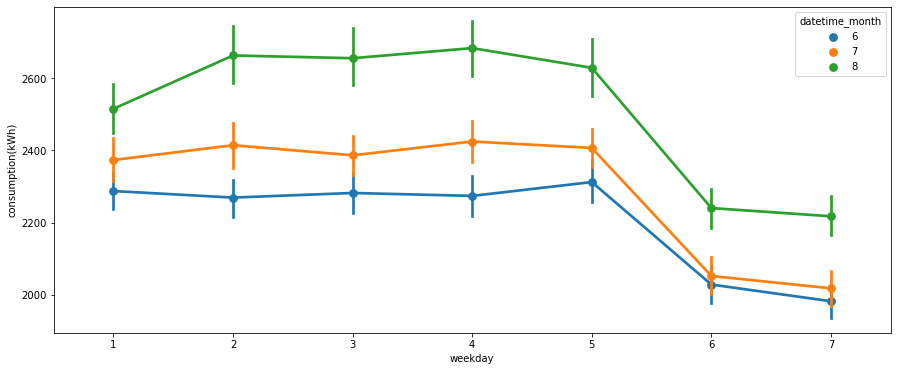

In [611]:
# 가장 많이 쓰는 요일 찾기.
plt.figure(figsize=(15,6))
sns.pointplot(data=train, x='weekday', y='consumption(kWh)', hue='datetime_month')

<AxesSubplot:xlabel='num', ylabel='consumption(kWh)'>

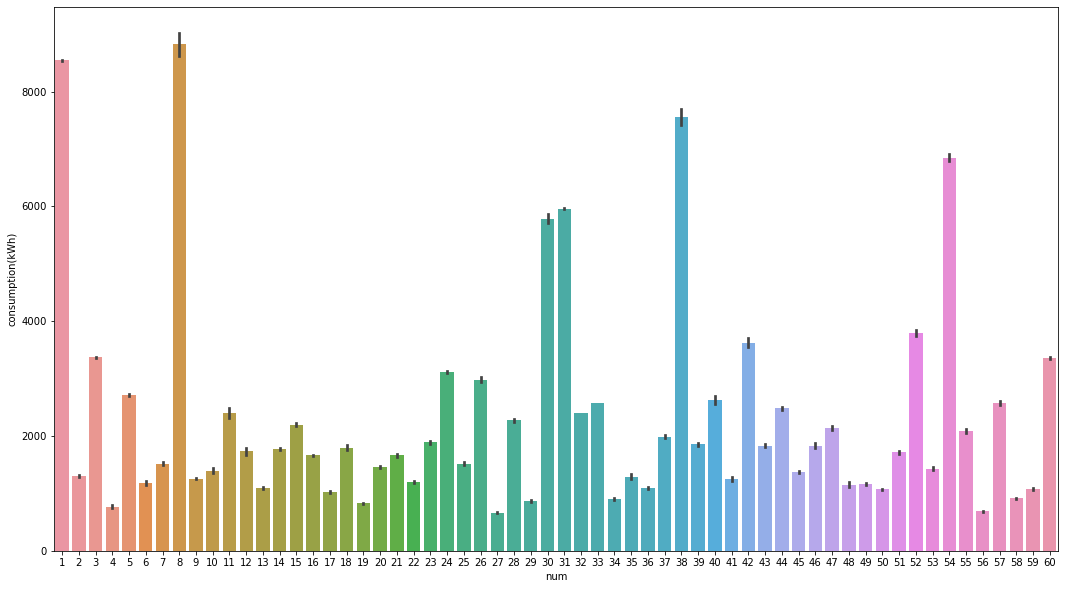

In [612]:
# 가장 많이 사용하는 시간대 확인
plt.figure(figsize=(18,10))
sns.barplot(data=train, x='num', y='consumption(kWh)')

In [613]:
train.columns

Index(['num', 'date_time', 'temperature', 'windspeed(m/s)', 'humidity(%)',
       'precipitation(mm)', 'sunshine(hr)', 'non_electric_cooling_system',
       'solar_cell', 'consumption(kWh)', 'datetime_year', 'datetime_month',
       'datetime_day', 'datetime_hour', 'datetime_minute', 'datetime_second',
       'weekday', 'datetime_weekday'],
      dtype='object')

In [614]:
train.T

,0,1,2,3,4,5,6,7,8,9,...,97910,97911,97912,97913,97914,97915,97916,97917,97918,97919
num,1,1,1,1,1,1,1,1,1,1,...,60,60,60,60,60,60,60,60,60,60
date_time,2020-06-01 00:00:00,2020-06-01 01:00:00,2020-06-01 02:00:00,2020-06-01 03:00:00,2020-06-01 04:00:00,2020-06-01 05:00:00,2020-06-01 07:00:00,2020-06-01 08:00:00,2020-06-01 09:00:00,2020-06-01 10:00:00,...,2020-08-24 12:00:00,2020-08-24 13:00:00,2020-08-24 14:00:00,2020-08-24 16:00:00,2020-08-24 18:00:00,2020-08-24 19:00:00,2020-08-24 20:00:00,2020-08-24 21:00:00,2020-08-24 22:00:00,2020-08-24 23:00:00
temperature,17.6,17.7,17.5,17.1,17.0,16.9,16.9,17.8,19.3,20.5,...,29.6,29.4,29.5,29.4,28.5,27.8,27.3,27.3,27.1,27.1
windspeed(m/s),2.5,2.9,3.2,3.2,3.3,3.4,2.3,3.3,2.1,3.4,...,3.0,2.3,3.1,3.1,2.2,2.3,1.2,1.8,1.8,2.6
humidity(%),92.0,91.0,91.0,91.0,92.0,93.0,86.0,80.0,73.0,62.0,...,58.0,60.0,59.0,59.0,66.0,68.0,71.0,71.0,74.0,75.0
precipitation(mm),0.8,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sunshine(hr),0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.7,1.0,...,1.0,1.0,1.0,1.0,1.0,0.7,0.0,0.0,0.0,0.0
non_electric_cooling_system,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
solar_cell,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
consumption(kWh),8179.056,8135.64,8107.128,8048.808,8043.624,8010.576,8019.0,8020.944,8083.152,8116.2,...,4257.36,4237.056,4269.456,4294.08,4189.104,4114.368,3975.696,3572.208,3299.184,3204.576


## 불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32

In [615]:
train["THI"]=1.8*train['temperature']-0.55*(1 - 0.01*train['humidity(%)'])*(1.8*train['temperature']-26)+32
train[['temperature','humidity(%)','THI']]

,temperature,humidity(%),THI
0,17.6,92.0,63.43008
1,17.7,91.0,63.56993
2,17.5,91.0,63.22775
3,17.1,91.0,62.54339
4,17.0,92.0,62.39760
...,...,...,...
97915,27.8,68.0,77.80896
97916,27.3,71.0,77.44917
97917,27.3,71.0,77.44917
97918,27.1,74.0,77.52246


In [616]:
test["THI"]=1.8*test['temperature']-0.55*(1 - 0.01*test['humidity(%)'])*(1.8*test['temperature']-26)+32
test[['temperature','humidity(%)','THI']]

,temperature,humidity(%),THI
0,16.7,90.0,61.83670
1,22.1,52.0,68.14208
2,23.1,42.0,68.60998
3,15.9,78.0,60.30298
4,15.5,79.0,59.68055
...,...,...,...
24475,24.7,78.0,74.22634
24476,24.6,80.0,74.26920
24477,27.1,61.0,75.89369
24478,29.5,58.0,78.83990


In [617]:
train['THI_1']=(train['THI']<68).astype(int)
train['THI_2']=((train['THI']>=68)&(train['THI']<75)).astype(int)
train['THI_3']=((train['THI']>=75)&(train['THI']<80)).astype(int)
train['THI_4']=(train['THI']>=80).astype(int)

train[(train['THI']>=68)&(train['THI']<75)][['THI','THI_1','THI_2','THI_3','THI_4']]

,THI,THI_1,THI_2,THI_3,THI_4
10,69.20981,0,1,0,0
11,68.95096,0,1,0,0
12,69.28280,0,1,0,0
13,69.90784,0,1,0,0
14,69.13224,0,1,0,0
...,...,...,...,...,...
97902,74.47028,0,1,0,0
97903,74.54016,0,1,0,0
97904,74.27645,0,1,0,0
97905,74.04174,0,1,0,0


In [618]:
test['THI_1']=(test['THI']<68).astype(int)
test['THI_2']=((test['THI']>=68)&(test['THI']<75)).astype(int)
test['THI_3']=((test['THI']>=75)&(test['THI']<80)).astype(int)
test['THI_4']=(test['THI']>=80).astype(int)

test[(test['THI']>=68)&(test['THI']<75)][['THI','THI_1','THI_2','THI_3','THI_4']]

,THI,THI_1,THI_2,THI_3,THI_4
1,68.14208,0,1,0,0
2,68.60998,0,1,0,0
8,74.36440,0,1,0,0
9,71.87616,0,1,0,0
12,68.18060,0,1,0,0
...,...,...,...,...,...
24472,71.88064,0,1,0,0
24473,72.45980,0,1,0,0
24474,73.59346,0,1,0,0
24475,74.22634,0,1,0,0


In [619]:
train.loc[train['THI']<68,'THI_type'] = 1
train.loc[(train['THI']>=68)&(train['THI']<75),'THI_type'] = 2
train.loc[(train['THI']>=75)&(train['THI']<80),'THI_type'] = 3
train.loc[train['THI']>=80,'THI_type'] = 4

train[(train['THI']>=68)]

,num,date_time,temperature,windspeed(m/s),humidity(%),precipitation(mm),sunshine(hr),non_electric_cooling_system,solar_cell,consumption(kWh),...,datetime_minute,datetime_second,weekday,datetime_weekday,THI,THI_1,THI_2,THI_3,THI_4,THI_type
10,1,2020-06-01 12:00:00,23.1,4.0,49.0,0.0,1.0,0,0,8088.984,...,0,0,1,Monday,69.20981,0,1,0,0,2.0
11,1,2020-06-01 14:00:00,23.6,5.1,39.0,0.0,1.0,0,0,8088.336,...,0,0,1,Monday,68.95096,0,1,0,0,2.0
12,1,2020-06-01 15:00:00,23.8,5.5,40.0,0.0,1.0,0,0,8076.672,...,0,0,1,Monday,69.28280,0,1,0,0,2.0
13,1,2020-06-01 16:00:00,24.4,3.0,39.0,0.0,1.0,0,0,8032.608,...,0,0,1,Monday,69.90784,0,1,0,0,2.0
14,1,2020-06-01 17:00:00,23.6,4.4,41.0,0.0,1.0,0,0,8013.816,...,0,0,1,Monday,69.13224,0,1,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97915,60,2020-08-24 19:00:00,27.8,2.3,68.0,0.0,0.7,1,1,4114.368,...,0,0,1,Monday,77.80896,0,0,1,0,3.0
97916,60,2020-08-24 20:00:00,27.3,1.2,71.0,0.0,0.0,1,1,3975.696,...,0,0,1,Monday,77.44917,0,0,1,0,3.0
97917,60,2020-08-24 21:00:00,27.3,1.8,71.0,0.0,0.0,1,1,3572.208,...,0,0,1,Monday,77.44917,0,0,1,0,3.0
97918,60,2020-08-24 22:00:00,27.1,1.8,74.0,0.0,0.0,1,1,3299.184,...,0,0,1,Monday,77.52246,0,0,1,0,3.0


In [620]:
test.loc[test['THI']<68,'THI_type'] = 1
test.loc[(test['THI']>=68)&(test['THI']<75),'THI_type'] = 2
test.loc[(test['THI']>=75)&(test['THI']<80),'THI_type'] = 3
test.loc[test['THI']>=80,'THI_type'] = 4

test[(test['THI']>=68)]

,num,date_time,temperature,windspeed(m/s),humidity(%),precipitation(mm),sunshine(hr),non_electric_cooling_system,solar_cell,datetime_year,...,datetime_hour,datetime_minute,datetime_second,weekday,THI,THI_1,THI_2,THI_3,THI_4,THI_type
1,1,2020-06-01 11:00:00,22.1,3.6,52.0,0.0,1.0,0,0,2020,...,11,0,0,1,68.14208,0,1,0,0,2.0
2,1,2020-06-01 13:00:00,23.1,5.1,42.0,0.0,1.0,0,0,2020,...,13,0,0,1,68.60998,0,1,0,0,2.0
8,1,2020-06-03 18:00:00,26.1,4.5,60.0,0.0,1.0,0,0,2020,...,18,0,0,3,74.36440,0,1,0,0,2.0
9,1,2020-06-03 19:00:00,23.8,4.8,68.0,0.0,0.8,0,0,2020,...,19,0,0,3,71.87616,0,1,0,0,2.0
12,1,2020-06-04 04:00:00,20.5,2.0,88.0,0.0,0.0,0,0,2020,...,4,0,0,4,68.18060,0,1,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24475,60,2020-08-24 01:00:00,24.7,0.7,78.0,0.0,0.0,1,1,2020,...,1,0,0,1,74.22634,0,1,0,0,2.0
24476,60,2020-08-24 02:00:00,24.6,0.9,80.0,0.0,0.0,1,1,2020,...,2,0,0,1,74.26920,0,1,0,0,2.0
24477,60,2020-08-24 09:00:00,27.1,2.4,61.0,0.0,1.0,1,1,2020,...,9,0,0,1,75.89369,0,0,1,0,3.0
24478,60,2020-08-24 15:00:00,29.5,3.4,58.0,0.0,1.0,1,1,2020,...,15,0,0,1,78.83990,0,0,1,0,3.0


In [621]:
train.columns

Index(['num', 'date_time', 'temperature', 'windspeed(m/s)', 'humidity(%)',
       'precipitation(mm)', 'sunshine(hr)', 'non_electric_cooling_system',
       'solar_cell', 'consumption(kWh)', 'datetime_year', 'datetime_month',
       'datetime_day', 'datetime_hour', 'datetime_minute', 'datetime_second',
       'weekday', 'datetime_weekday', 'THI', 'THI_1', 'THI_2', 'THI_3',
       'THI_4', 'THI_type'],
      dtype='object')

In [622]:
test.columns

Index(['num', 'date_time', 'temperature', 'windspeed(m/s)', 'humidity(%)',
       'precipitation(mm)', 'sunshine(hr)', 'non_electric_cooling_system',
       'solar_cell', 'datetime_year', 'datetime_month', 'datetime_day',
       'datetime_hour', 'datetime_minute', 'datetime_second', 'weekday', 'THI',
       'THI_1', 'THI_2', 'THI_3', 'THI_4', 'THI_type'],
      dtype='object')

In [623]:
train.head()

,num,date_time,temperature,windspeed(m/s),humidity(%),precipitation(mm),sunshine(hr),non_electric_cooling_system,solar_cell,consumption(kWh),...,datetime_minute,datetime_second,weekday,datetime_weekday,THI,THI_1,THI_2,THI_3,THI_4,THI_type
0,1,2020-06-01 00:00:00,17.6,2.5,92.0,0.8,0.0,0,0,8179.056,...,0,0,1,Monday,63.43008,1,0,0,0,1.0
1,1,2020-06-01 01:00:00,17.7,2.9,91.0,0.3,0.0,0,0,8135.640,...,0,0,1,Monday,63.56993,1,0,0,0,1.0
2,1,2020-06-01 02:00:00,17.5,3.2,91.0,0.0,0.0,0,0,8107.128,...,0,0,1,Monday,63.22775,1,0,0,0,1.0
3,1,2020-06-01 03:00:00,17.1,3.2,91.0,0.0,0.0,0,0,8048.808,...,0,0,1,Monday,62.54339,1,0,0,0,1.0
4,1,2020-06-01 04:00:00,17.0,3.3,92.0,0.0,0.0,0,0,8043.624,...,0,0,1,Monday,62.39760,1,0,0,0,1.0


## 체감온도 : 13.12 + 0.6215*T - 11.37V^0.16 + 0.3965V^0.16 * T

In [624]:
train['atemp'] = 13.12 + 0.6215 * train['temperature'] - 11.37 * (train['windspeed(m/s)'] * 2 * 0.16) + 0.3965 * (train['windspeed(m/s)'] * 2 * 0.16) * train['temperature']

In [625]:
test['atemp'] = 13.12 + 0.6215 * test['temperature'] - 11.37 * (test['windspeed(m/s)'] * 2 * 0.16) + 0.3965 * (test['windspeed(m/s)'] * 2 * 0.16) * test['temperature']

## 머신러닝

In [626]:
X = train.drop(['date_time', 'datetime_weekday', 'datetime_weekday', 'consumption(kWh)'], axis = 1)
y = train['consumption(kWh)']
X_test = test.drop('date_time', axis = 1)

In [627]:
n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(X_test))

# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for tr_idx, val_idx in sfk.split(X, X['num']):      
    X_train = X.iloc[tr_idx, :]
    y_train = y[tr_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.1,objective = 'mse')
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 100)
    y_pred += lgbm.predict(X_test) / n_splits

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 342.586	valid_0's l2: 117365
[200]	valid_0's rmse: 303.849	valid_0's l2: 92324
[300]	valid_0's rmse: 288.617	valid_0's l2: 83299.5
[400]	valid_0's rmse: 283.326	valid_0's l2: 80273.8
[500]	valid_0's rmse: 279.292	valid_0's l2: 78003.9
[600]	valid_0's rmse: 276.077	valid_0's l2: 76218.5
[700]	valid_0's rmse: 273.968	valid_0's l2: 75058.4
[800]	valid_0's rmse: 272.578	valid_0's l2: 74298.6
[900]	valid_0's rmse: 271.371	valid_0's l2: 73642
Early stopping, best iteration is:
[946]	valid_0's rmse: 270.892	valid_0's l2: 73382.6
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 304.532	valid_0's l2: 92739.5
[200]	valid_0's rmse: 262.787	valid_0's l2: 69057.1
[300]	valid_0's rmse: 247.245	valid_0's l2: 61130.2
[400]	valid_0's rmse: 238.993	valid_0's l2: 57117.7
[500]	valid_0's rmse: 231.798	valid_0's l2: 53730.5
[600]	valid_0's rmse: 227.885	valid_0's l2: 51931.8
[700]	valid_0's 

In [481]:
# 브로드한 하이퍼 파라메타 ( 브로우 한건 결과가 좋지 않을 수 있다. 대신 범위를 좁혀가면서 좋은 값을 찾아간다 )
coarse_hyperparameters_list = []

# 100개 중 랜덤으로 튜닝을 해서 값을 추출한다. (복불복)
# num_epoch = 100~1000 등 다양하게 tunning 함.
num_epoch = 100

for epoch in range(num_epoch):
    
    #n_estimators = np.random.randint(low = 100, high = 9000)
    max_depth = np.random.randint(low = -1, high = 30)
    
    # 과적합을 방지하기 위해 절반으로 줄여준다.
    leaves = np.random.randint(low = 1, high = 14)
    num_leaves = (2**leaves)-1
        
    # 랜덤으로 1 ~ 4 사이의 값이 나온다.
    lr = np.random.uniform(low = 1, high = 4)
    learning_rate = 3*(10**(-lr))
    
    colsample_bytree = np.random.uniform(low=0.4, high=1)
    subsample = np.random.uniform(low=0.4,high=1)
    
    r_alpha = np.random.uniform(low=0, high = 100)
    r_lambda = np.random.uniform(low=0, high = 100)
    
    for col in range(4):
        # hhb, hbo2, ca, na 순으로 컬럼을 Ytrain_temp에 하나만 저장함.
        y_train_temp = y_train[y_train.columns[col]].copy()

        y_pred = np.zeros(len(X_test))
        x_label = np.zeros(len(X_train))
        result = 0
        n_splits = 5
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        X_train_f = X_train.drop(['probe_'+y_train.columns[col]],axis=1)
        Xtest_f = X_test.drop(['probe_'+y_train.columns[col]],axis=1)


        for n_fold, (tr_idx, val_idx) in enumerate(kf.split(Xtrain_f)):
            tr_idx = Xtrain_f.iloc[tr_idx],y_train_temp.iloc[tr_idx]
            val_idx = Xtrain_f.iloc[val_idx], y_train_temp.iloc[val_idx]

            # 모델의 튜닝조건
            lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.1,objective = 'mse')
            # 모델의 학습
            lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 50,verbose = 100)

            y_pred += lgbm.predict(X_test) / n_splits
            x_label += lgbm.predict(X_train_f) / n_splits 
            val_pred = lgbm.predict(val_idx)
            result += np.mean((np.abs(val_idx - val_pred))) / n_splits     
            #print(result)
        sub[y_train.columns[col]] = y_pred
        output[y_train.columns[col]] = result
        
    # output = result 값 중 평균을 score에 넣는다.
    scores = output.loc[0].mean()

    hyperparameters = {
        'epoch' : epcoh,
        'scores' : scores,
        'lr' : lr,
        'num_leaves' : leaves,
        'max_depth' : max_depth,
        'n_estimators' : 10000,
        'colsample_bytree' : colsample_bytree,
        'subsample' : subsample,
        'num_iterations' : num_iterations,
        'reg_alpha' : r_alpha,
        'reg_lambda' : r_lambda,
    }

    # 추출 된 데이터를 List 안에 넣는다 ( EPOCH 0~ 100 범위)
    coarse_hyperparameters_list.append(hyperparameters)

    # 2 는 100단위, .4f 는 소수점으로 나온다.
    print(f"{epoch:2} scores={scores:.4f}, lr={lr:.4f}, leaves={leaves:2}, max_depth={max_depth:2}, colsample_bytree={colsample_bytree:.4f}, subsample={subsample:.4f}, r_alpha={r_alpha:.4f}, r_lambda={r_lambda:.4f}")

# 리스트를 데이터프레임으로 만들고
coarse_hyperparameters_dataframe = pd.DataFrame = pd.DataFrame.from_dict(coarse_hyperparameters_list)

# 정렬시킨다. 스코어가 가장 낮은 순으로
coarse_hyperparameters_dataframe = coarse_hyperparameters_dataframe.sort_values(by="scores")
print(coarse_hyperparameters_dataframe.shape)
# 상위 10위를 뽑겠다
coarse_hyperparameters_dataframe.head(10)

AttributeError: 'Series' object has no attribute 'columns'

In [628]:
train.to_csv('train 제출용.csv')

In [629]:
test.to_csv('test 제출용.csv')